In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import pyplot
import geopandas

In [2]:
# path = open('document.txt', 'r').read().strip()
# os.listdir(f'{path}')

# df_data = pd.DataFrame([])
# for year in range(2015,2019):
#     df_temp = pd.read_feather(f"{path}/{year}_street.feather")
#     filter = df_temp['Falls within'].str.contains('South Wales')
#     df_temp = df_temp[filter]
#     df_temp = df_temp[df_temp['Crime type']=='Violence and sexual offences']
#     df_temp = df_temp['Month'].value_counts().sort_index()
#     df_data = pd.concat([df_data, df_temp])
#     del df_temp

In [48]:
path = open('document.txt', 'r').read().strip()
df_data = pd.read_feather(f"{path}/{2015}_street.feather")
# df_data = df_data.drop('Context', axis=1)
# wales = df_data['Falls within'].str.contains('South Wales')
# df_data = df_data[wales].sort_values(by=['Month'])
# df_data = df_data.drop(['Reported by', 'Falls within', 'Crime ID'], axis=1)



In [ ]:
df_data['Falls within'].unique()

KeyError: 'Falls within'

In [32]:
path = open('geopandas.txt', 'r').read().strip()

df_boundaries = geopandas.read_file(path)

<AxesSubplot:>

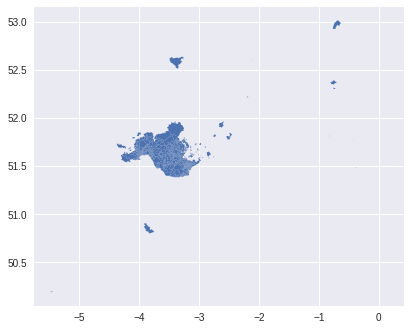

In [44]:
df_boundaries[df_boundaries['LSOA11CD'].isin(lsoa)].plot()

In [42]:
lsoa = df_data['LSOA code'].unique()

In [30]:
# df_boundaries.explore()

In [14]:
df_data = df_data.groupby('LSOA code')

In [15]:
df_data['Location'].value_counts().to_frame().head(50)

,,Location
LSOA code,Location,
E01000086,On or near Combes Road,1
E01002620,On or near The Warren,1
E01010486,On or near Old Fallings Crescent,1
E01014049,On or near The Pippins,1
E01017712,On or near Penn Road,1
E01018986,On or near Carninney Lane,1
E01020072,On or near Beer Lane,1
E01022249,On or near Howell'S Lane,1
E01023437,On or near Darwin Close,1


In [16]:
df_data['Last outcome category'].value_counts()

LSOA code  Last outcome category                   
E01000086  Unable to prosecute suspect                 1
E01002620  Court result unavailable                    1
E01010486  Under investigation                         1
E01014049  Unable to prosecute suspect                 1
E01017712  Under investigation                         1
                                                      ..
W01001958  Offender given penalty notice               1
           Offender given suspended prison sentence    1
           Offender ordered to pay compensation        1
           Offender otherwise dealt with               1
           Suspect charged as part of another case     1
Name: Last outcome category, Length: 8364, dtype: int64

In [18]:
df_data.head(10)

,Month,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category
5185263,2015-01,-3.232554,51.486302,On or near Oxwich Close,W01001754,Cardiff 031D,Vehicle crime,Investigation complete; no suspect identified
5188837,2015-01,-3.371347,51.673537,On or near Morgan Street,W01001212,Rhondda Cynon Taf 008D,Anti-social behaviour,None
5188838,2015-01,-3.372196,51.674346,On or near Mount Pleasant Place,W01001212,Rhondda Cynon Taf 008D,Anti-social behaviour,None
5188839,2015-01,-3.372010,51.674905,On or near Hughes Street,W01001212,Rhondda Cynon Taf 008D,Anti-social behaviour,None
5188840,2015-01,-3.371724,51.674999,On or near Jones Street,W01001212,Rhondda Cynon Taf 008D,Criminal damage and arson,Investigation complete; no suspect identified
...,...,...,...,...,...,...,...,...
377315,2015-12,-2.601188,51.915241,On or near The Pippins,E01014049,Herefordshire 023C,Drugs,Unable to prosecute suspect
377314,2015-12,-4.058443,51.724956,On or near Plas-Y-Fforest,W01000665,Carmarthenshire 017A,Anti-social behaviour,None
373896,2015-12,-3.228044,51.659145,On or near Farm Close,W01001363,Caerphilly 012A,Other crime,Unable to prosecute suspect
378655,2015-12,-3.778832,51.767758,On or near Petrol Station,W01000502,Powys 021C,Criminal damage and arson,Investigation complete; no suspect identified


In [ ]:
# df_data[~df_data['Context'].isna()]
